# 导入数据

In [47]:
import torch
import torch.nn as nn
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime,timedelta

In [48]:
data_file = '大黑楼逐日.csv'
sensor_code='210200D11103009'

In [49]:
data_list_tmp=[]
with open(data_file, 'r', encoding='UTF-8') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0]==sensor_code:
            data_list_tmp.append([datetime(2019,int(row[4]),int(row[5]),0,0),float(row[3])])
start_date=data_list_tmp[0][0]
end_date=data_list_tmp[-1][0]
date_list=pd.date_range(start=start_date,end=end_date).tolist()
data_list=[]
j=0
for i in date_list:
    if data_list_tmp[j][0]==i:
        data_list.append([i,data_list_tmp[j][1]])
        j=j+1
    else:
        data_list.append([i,math.nan])
while math.isnan(data_list[0][1]):
    del(data_list[0])
while math.isnan(data_list[-1][1]):
    del(data_list[-1])
data_set=np.array(data_list)
data_series=pd.Series(data_set[:,1],index=data_set[:,0]).astype(float)

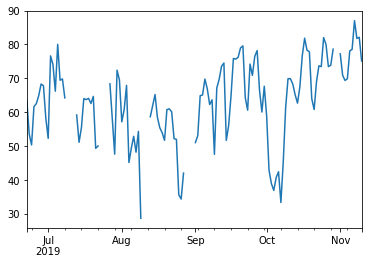

In [50]:
data_series.plot()

# 填补缺失值

In [51]:
data_series=data_series.astype(float).interpolate()

In [52]:
data_series

2019-06-22    63.572
2019-06-23    53.556
2019-06-24    50.338
2019-06-25    61.640
2019-06-26    62.526
               ...  
2019-11-06    78.568
2019-11-07    87.028
2019-11-08    81.768
2019-11-09    82.118
2019-11-10    75.104
Length: 142, dtype: float64

# 划分测试集

In [53]:
train_proportion=0.9
train_length=int(len(data_series)*train_proportion)
test_length=len(data_series)-train_length
data_train=data_series[0:train_length]
data_test=data_series[train_length:]

In [54]:
data_train

2019-06-22    63.572
2019-06-23    53.556
2019-06-24    50.338
2019-06-25    61.640
2019-06-26    62.526
               ...  
2019-10-22    69.018
2019-10-23    73.686
2019-10-24    73.456
2019-10-25    82.024
2019-10-26    79.990
Length: 127, dtype: float64

In [55]:
data_test

2019-10-27    73.462
2019-10-28    73.860
2019-10-29    78.608
2019-10-30    78.146
2019-10-31    77.684
2019-11-01    77.222
2019-11-02    70.908
2019-11-03    69.364
2019-11-04    69.860
2019-11-05    78.078
2019-11-06    78.568
2019-11-07    87.028
2019-11-08    81.768
2019-11-09    82.118
2019-11-10    75.104
dtype: float64

# 构建神经网络

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(np.array(data_train.tolist()).reshape(-1, 1))

In [57]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

In [58]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [59]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [60]:
train_inout_seq[:5]

[(tensor([ 0.3085, -0.0669, -0.1875,  0.2361,  0.2693,  0.3561,  0.4860]),
  tensor([0.4680])),
 (tensor([-0.0669, -0.1875,  0.2361,  0.2693,  0.3561,  0.4860,  0.4680]),
  tensor([0.1067])),
 (tensor([-0.1875,  0.2361,  0.2693,  0.3561,  0.4860,  0.4680,  0.1067]),
  tensor([-0.1151])),
 (tensor([ 0.2361,  0.2693,  0.3561,  0.4860,  0.4680,  0.1067, -0.1151]),
  tensor([0.7973])),
 (tensor([ 0.2693,  0.3561,  0.4860,  0.4680,  0.1067, -0.1151,  0.7973]),
  tensor([0.7024]))]

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [62]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# 训练神经网络

In [64]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.09496472
epoch:  26 loss: 0.00389938
epoch:  51 loss: 0.04557109
epoch:  76 loss: 0.00090481
epoch: 101 loss: 0.00210930
epoch: 126 loss: 0.00038219
epoch: 149 loss: 0.0034646895


# 结果预测

In [65]:
fut_pred = test_length
test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [66]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[75.34141879]
 [67.59055161]
 [73.1559936 ]
 [62.66702416]
 [63.21969884]
 [71.57233332]
 [70.42424432]
 [57.53892438]
 [51.31129304]
 [64.36329011]
 [49.0832455 ]
 [48.25838172]
 [44.59105361]
 [42.41194879]
 [45.35230214]]


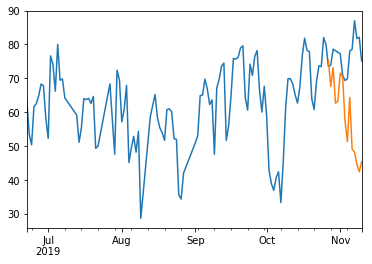

In [67]:
plt.autoscale(axis='x', tight=True)
data_series.plot()
pred_data=pd.Series(actual_predictions.reshape(1,-1)[0],index=data_test.index)
pred_data.plot()
plt.show()

In [68]:
accuracy=1-(abs(pred_data-real_data)/real_data).mean()
print(accuracy)

0.16862520063979247
